# 1st COMputing CHAllenges School <a class="tocSkip">

## Hands-on Principal Component Analysis <a class="tocSkip">
  
*Barcelona, October 4th, 2019*

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-eigenfaces-example:-chaining-PCA-and-a-classifier" data-toc-modified-id="The-eigenfaces-example:-chaining-PCA-and-a-classifier-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The eigenfaces example: chaining PCA and a classifier</a></span><ul class="toc-item"><li><span><a href="#Preprocessing:-Principal-Component-Analysis" data-toc-modified-id="Preprocessing:-Principal-Component-Analysis-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Preprocessing: Principal Component Analysis</a></span></li><li><span><a href="#Doing-the-Learning:-Support-Vector-Machines" data-toc-modified-id="Doing-the-Learning:-Support-Vector-Machines-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Doing the Learning: Support Vector Machines</a></span></li></ul></li></ul></div>


The eigenfaces example: chaining PCA and a classifier
=============================================

The goal of this example is to show how an unsupervised method and a
supervised one can be chained for better prediction.

Here we'll take a look at a simple facial recognition example.



In [92]:
# Get dataset

from sklearn import datasets
import numpy as np
from matplotlib import pyplot as plt

In [93]:
faces = datasets.fetch_olivetti_faces(data_home='Data')

Let's visualize these faces to see what we're working with:

Number of classes:  40


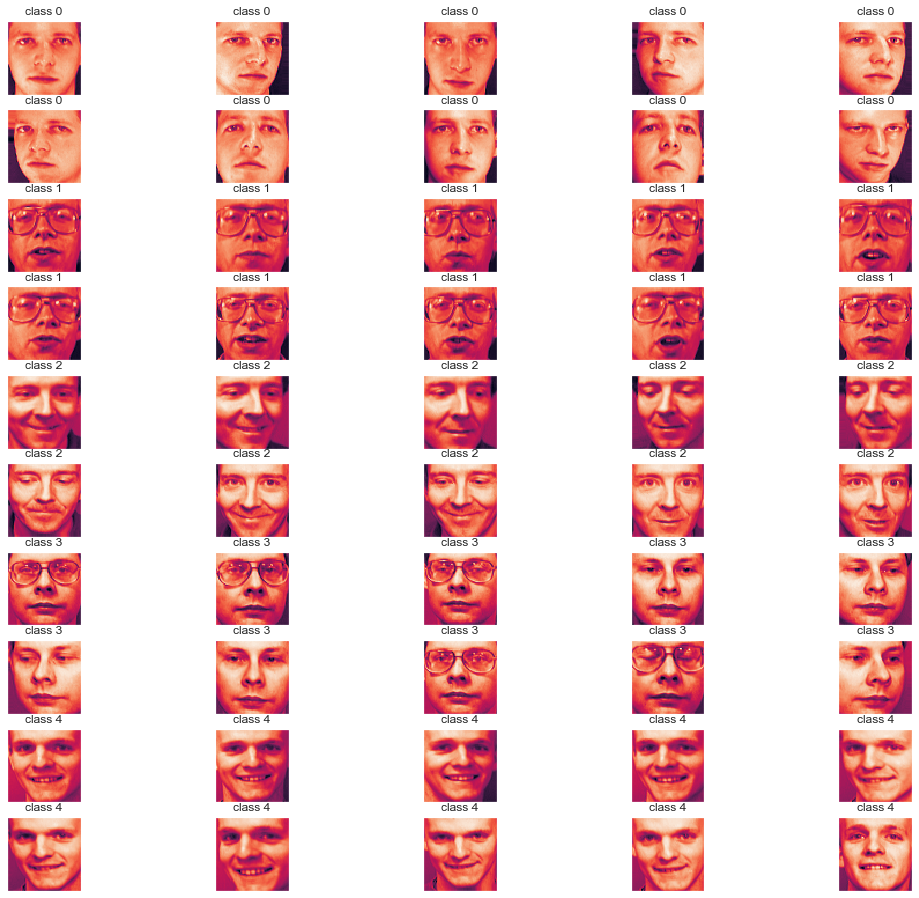

In [181]:
print('Number of classes: ', len(np.unique(faces.target)))

fig = plt.figure(figsize=(18, 16))

for i in range(50):
    ax = fig.add_subplot(10, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(faces.images[i])   
    ax.set_title('class ' + str(faces.target[i]))

plt.show()

We'll perform a Support Vector classification of the images (More on [Support Vector Machine algorithm](https://scikit-learn.org/stable/modules/svm.html)).

We'll do a typical train-test split on the sample:



In [184]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target, random_state=0)

print('Initial sample size:', faces.data.shape)
print('Train sample size:  ', X_train.shape)
print('Train sample size:  ', X_test.shape)

Initial sample size: (400, 4096)
Train sample size:   (300, 4096)
Train sample size:   (100, 4096)


Preprocessing: Principal Component Analysis
-------------------------------------------

Just a cheat sheet:

- $n$ - number of objects;
- $m$ - original dimensionality;
- $d$ - target dimensionality;
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;

    $$\|(X W) \hat{W} - X\|^2_2 \to {W, \hat{W}} \min$$

4096 dimensions is a lot for SVM. We can use PCA to reduce these 4096
features to a manageable size, while maintaining most of the information
in the dataset.



In [143]:
from sklearn.decomposition import PCA

pca = PCA(n_components=150, whiten=True)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

One interesting part of PCA is that it computes the "mean" face, which
can be interesting to examine:



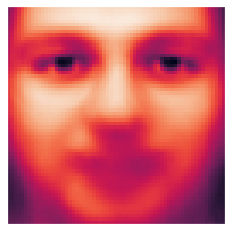

In [144]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
ax.imshow(pca.mean_.reshape(faces.images[0].shape))

The principal components measure deviations about this mean along
orthogonal axes.



In [145]:
print(pca.components_.shape)

(150, 4096)


It is also interesting to visualize these principal components:



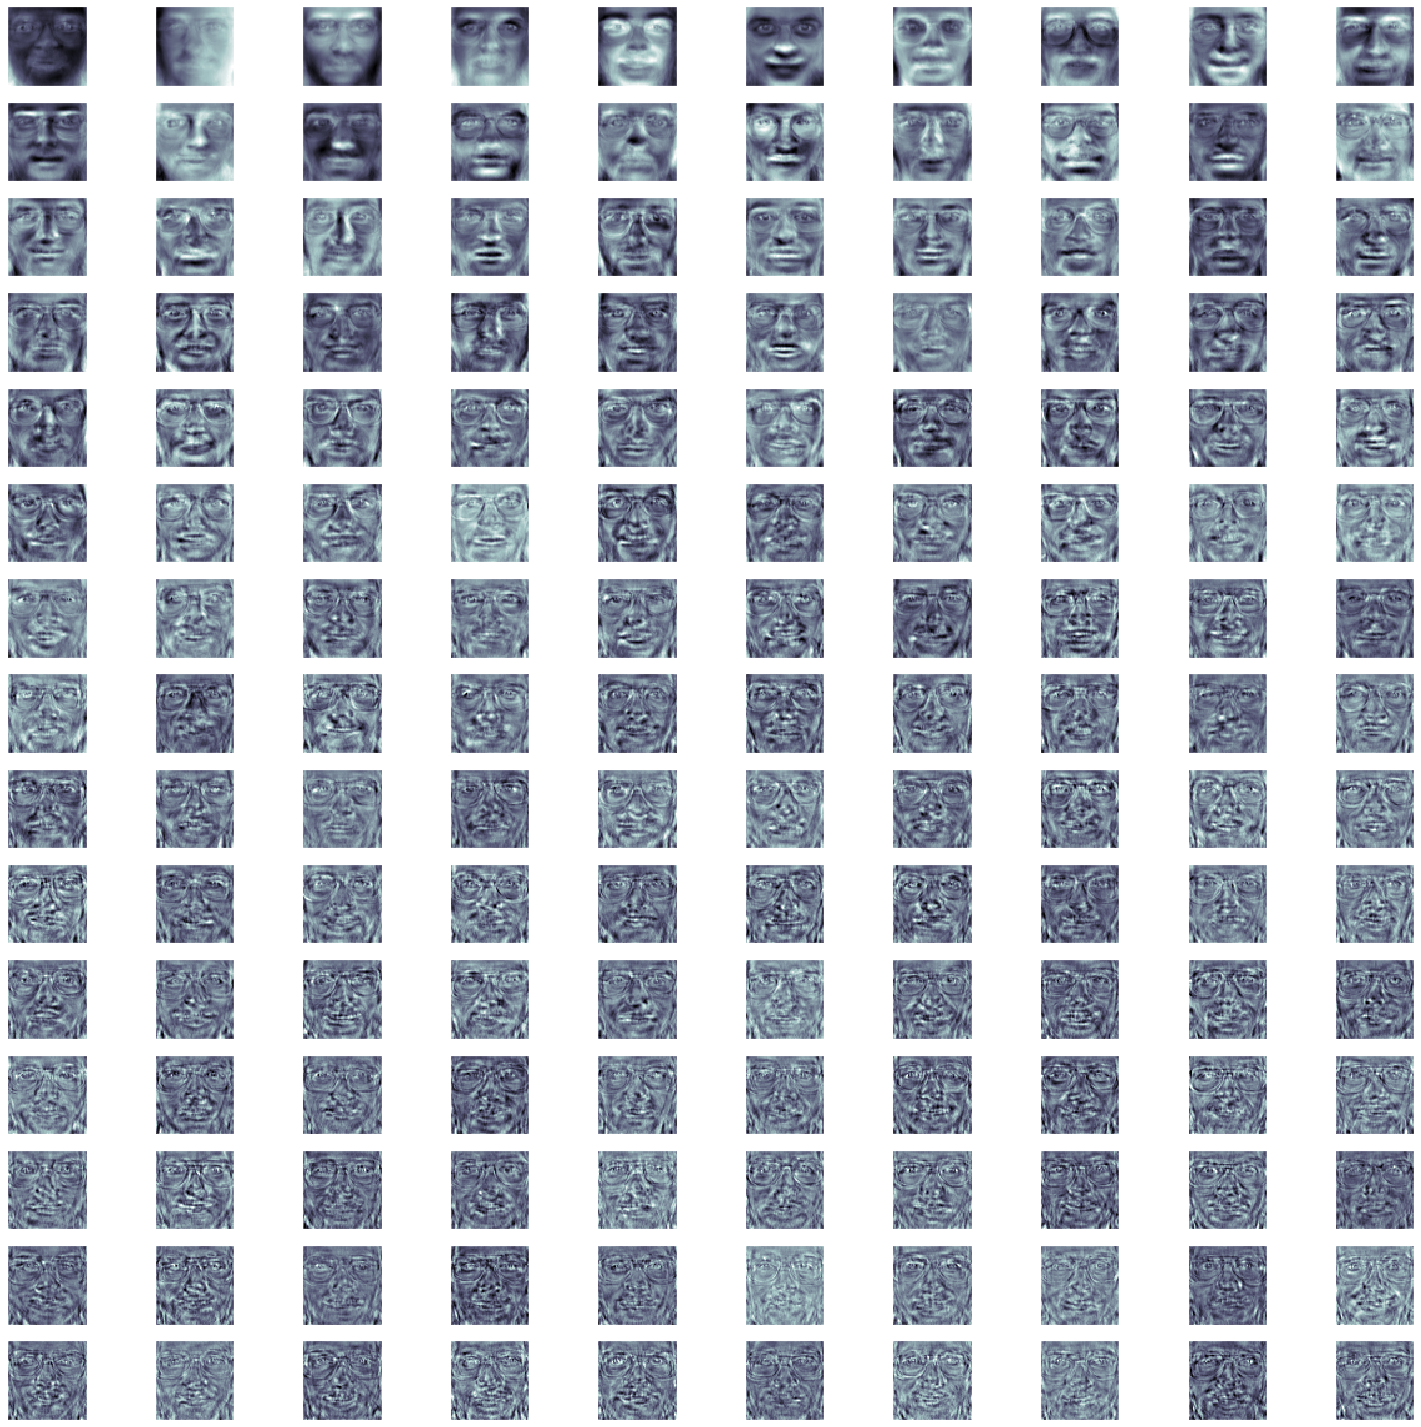

In [146]:
fig = plt.figure(figsize=(26, 26))

for i in range(150):
    ax = fig.add_subplot(15, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(faces.images[0].shape),
              cmap=plt.cm.bone)

The components ("eigenfaces") are ordered by their importance from
top-left to bottom-right. We see that the first few components seem to
primarily take care of lighting conditions; the remaining components
pull out certain identifying features: the nose, eyes, eyebrows, etc.

With this projection computed, we can now project our original training
and test data onto the PCA basis:



In [188]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print('Shape of train/test samples before transformation:')
print(X_train.shape)
print(X_test.shape)

print('\nShape of train/test samples after transformation:')
print(X_train_pca.shape)
print(X_test_pca.shape)

Shape of train/test samples before transformation:
(300, 4096)
(100, 4096)

Shape of train/test samples after transformation:
(300, 150)
(100, 150)


These projected components correspond to factors in a linear combination
of component images such that the combination approaches the original
face.

Doing the Learning: Support Vector Machines
-------------------------------------------

Now we'll perform support-vector-machine classification on this reduced
dataset:



In [153]:
from sklearn import svm

clf = svm.SVC(C=5., gamma=0.001)
clf.fit(X_train_pca, y_train)

SVC(C=5.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Finally, we can evaluate how well this classification did:


In [190]:
y_pred = clf.predict(X_test_pca)

Let's plot a few of the test-cases with the labels learned from the
training set (green=correct guess):


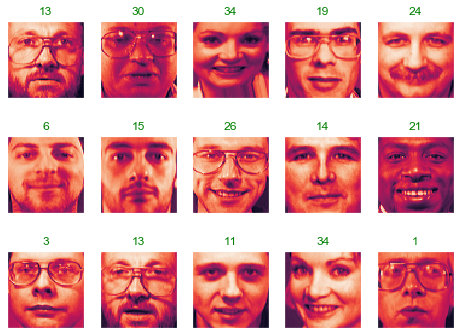

In [191]:
fig = plt.figure(figsize=(8, 6))

for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[i].reshape(faces.images[0].shape))
    color = ('green' if y_pred[i] == y_test[i] else 'red')
    ax.set_title(y_test[i], color=color)

In [201]:
print('Fraction of correct predictions:', np.count_nonzero((y_pred - y_test)==0) / 100)

Fraction of correct predictions: 0.93


The classifier is correct on an impressive number of images given the
simplicity of its learning model! Using a linear classifier on 150
features derived from the pixel-level data, the algorithm correctly
identifies a large number of the people in the images.

An interesting metric to quantify the effectiveness of the classifier is the *confusion matrix*, which indicates
how often any two items are mixed-up. The confusion matrix of a perfect
classifier would only have nonzero entries on the diagonal, with zeros
on the off-diagonal:



In [179]:
cm = metrics.confusion_matrix(y_test, y_pred)

print('Number of classes represented in test sample', len(np.unique(y_test)))

Number of classes represented in test sample 37


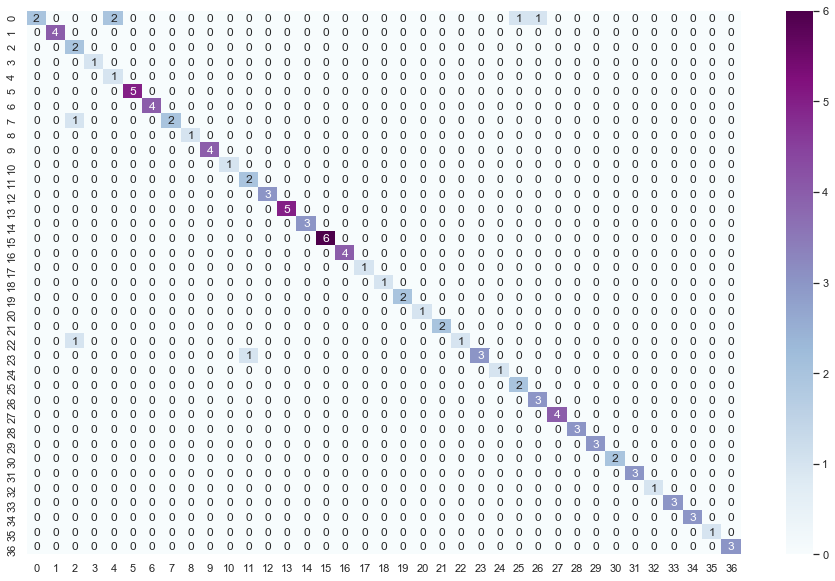

In [203]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

     
df_cm = pd.DataFrame(cm)
fig, ax = plt.subplots(figsize=(16,10)) 
sn.heatmap(df_cm, ax=ax, cmap='BuPu', annot=True)